# Task 1a: Consumer-Level Flexibility Models

## Problem Description

We consider the individual load scheduling problem of a single flexible consumer, and analyze how different types of flexible assets, flexibility preferences, and cost structures may impact its flexibility and profits.

### Task 1a Objectives

In this first subtask, we consider a consumer with:
- **Single fully flexible load**: Can be scheduled optimally across all hours
- **Rooftop PV panel**: Known hourly production profile that can be fully curtailed
- **Grid connection**: Can buy/sell electricity with hourly pricing and grid tariffs

### Key Constraints & Assumptions

1. **Load Flexibility**: Load is fully flexible in each hour but must satisfy minimum daily energy consumption
2. **PV Production**: Maximum hourly PV production is perfectly known and can be curtailed
3. **Grid Interaction**: Consumer pays/receives hourly electricity prices plus grid tariff fees for net imports/exports
4. **Objective**: Minimize daily energy procurement cost

### Analysis Framework

We will analyze how different cost structures impact consumer flexibility and profits across multiple scenarios:
- **Base scenario**: Standard pricing with import/export tariffs
- **Constant price**: Flat electricity pricing
- **Net metering**: Zero grid tariffs (import/export at market price)
- **No export**: Unfavorable export pricing
- **Price spike**: Evening price volatility

## Notebook Outline

1. **Setup & Data Loading**: Import libraries
2. **Data Loading**: Load input parameters
3. **Model Formulation**: Build linear programming model for Task 1a
4. **Scenario Analysis**: Run optimization across different pricing scenarios
5. **Results Visualization**: Plot energy flows and dual variables
6. **Comparative Analysis**: Summary tables and multi-scenario plots

## 1. Setup & Dependencies

Import required libraries for optimization, data processing, and visualization.

In [1]:
import json
from pathlib import Path
from dataclasses import dataclass, field
from typing import Dict, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gurobipy as gp
from gurobipy import GRB

Load utility modules for data handling, plotting, optimization classes, and helper functions.

In [2]:
import utils.data as data
import utils.plots as plots
import utils.classes as classes
import utils.helpers as helpers

## 2. Data Configuration

Set the data directory for Task 1a input parameters.

In [3]:
DATA_DIR = Path("data/question_1a")

## 3. Model Formulation

### Linear Programming Model for Task 1a

The optimization model minimizes daily energy procurement cost subject to:

**Decision Variables:**
- `l[t]`: Load consumption in hour t (kWh) 
- `p[t]`: PV self-consumption in hour t (kWh)
- `e[t]`: Grid imports in hour t (kWh)
- `s[t]`: PV exports in hour t (kWh) 
- `c[t]`: PV curtailment in hour t (kWh)

**Objective Function:**
Minimize: ∑ₜ [(πₜ + τᵢᵐᵖ)·eₜ - (πₜ - τᵉˣᵖ)·sₜ]

**Constraints:**
1. **Daily minimum consumption**: ∑ₜ lₜ ≥ L_min
2. **Hourly load balance**: lₜ = pₜ + eₜ  ∀t
3. **PV allocation**: pₜ + sₜ + cₜ = P^PV_t  ∀t  
4. **Load capacity**: lₜ ≤ l_max  ∀t

In [4]:
def build_input_data(base, scenario):
    T = base["T"]
    price = scenario["price"]
    imp   = scenario["imp"]
    exp   = scenario["exp"]
    P_pv  = base["P_pv"]
    L_min = base["L_min"]
    l_max = base["l_max_hour"]

    VARIABLES = []
    for t in range(T):
        VARIABLES += [f"l[{t}]", f"p[{t}]", f"e[{t}]", f"s[{t}]", f"c[{t}]"]

    objective_coeff = {v: 0 for v in VARIABLES}
    for t in range(T):
        objective_coeff[f"e[{t}]"] = price[t] + imp[t]
        objective_coeff[f"s[{t}]"] = -(price[t] - exp[t])

    constraints_coeff = {v: [] for v in VARIABLES}
    constraints_rhs = []
    constraints_sense = []

    # (1) Daily minimum consumption
    for v in VARIABLES:
        constraints_coeff[v].append(1.0 if v.startswith("l[") else 0.0)
    constraints_rhs.append(L_min)
    constraints_sense.append(GRB.GREATER_EQUAL)

    # (2) Hourly load balance: l_t = p_t + e_t
    for t in range(T):
        for v in VARIABLES:
            if v == f"l[{t}]": coeff = 1.0
            elif v == f"p[{t}]": coeff = -1.0
            elif v == f"e[{t}]": coeff = -1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(0.0)
        constraints_sense.append(GRB.EQUAL)

    # (3) PV split: p_t + s_t + c_t = P^{PV}_t
    for t in range(T):
        for v in VARIABLES:
            if v == f"p[{t}]": coeff = 1.0
            elif v == f"s[{t}]": coeff = 1.0
            elif v == f"c[{t}]": coeff = 1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(P_pv[t])
        constraints_sense.append(GRB.EQUAL)

    # (4) Hourly load maximum: l_t <= l_max[t]
    for t in range(T):
        for v in VARIABLES:
            coeff = 1.0 if v == f"l[{t}]" else 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(l_max[t])
        constraints_sense.append(GRB.LESS_EQUAL)

    return classes.InputData(VARIABLES, objective_coeff, constraints_coeff, constraints_rhs, constraints_sense)

## 4. Data Loading & Scenario Setup

Load input parameters and create different pricing scenarios for analysis.

In [5]:
appliance_params, bus_params, consumer_params, der_prod, usage_pref = data.load_inputs(DATA_DIR)
base = data.prepare_base_inputs(appliance_params, bus_params, der_prod, usage_pref)
scenarios = data.make_scenarios(base)

## 5. Scenario Analysis

### 5.1 Base Scenario

Standard pricing with import tariffs (0.2 DKK/kWh) and export tariffs (0.1 DKK/kWh). This represents typical grid connection costs.

Set parameter Username
Set parameter LicenseID to value 2625590
Academic license - for non-commercial use only - expires 2026-02-20
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 73 rows, 120 columns and 192 nonzeros
Model fingerprint: 0xc2749489
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+01]
Presolve removed 57 rows and 66 columns
Presolve time: 0.00s
Presolved: 16 rows, 54 columns, 69 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1224500e+01   2.400000e+01   0.000000e+00      0s
       2    1.4377500e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.437750000e+01


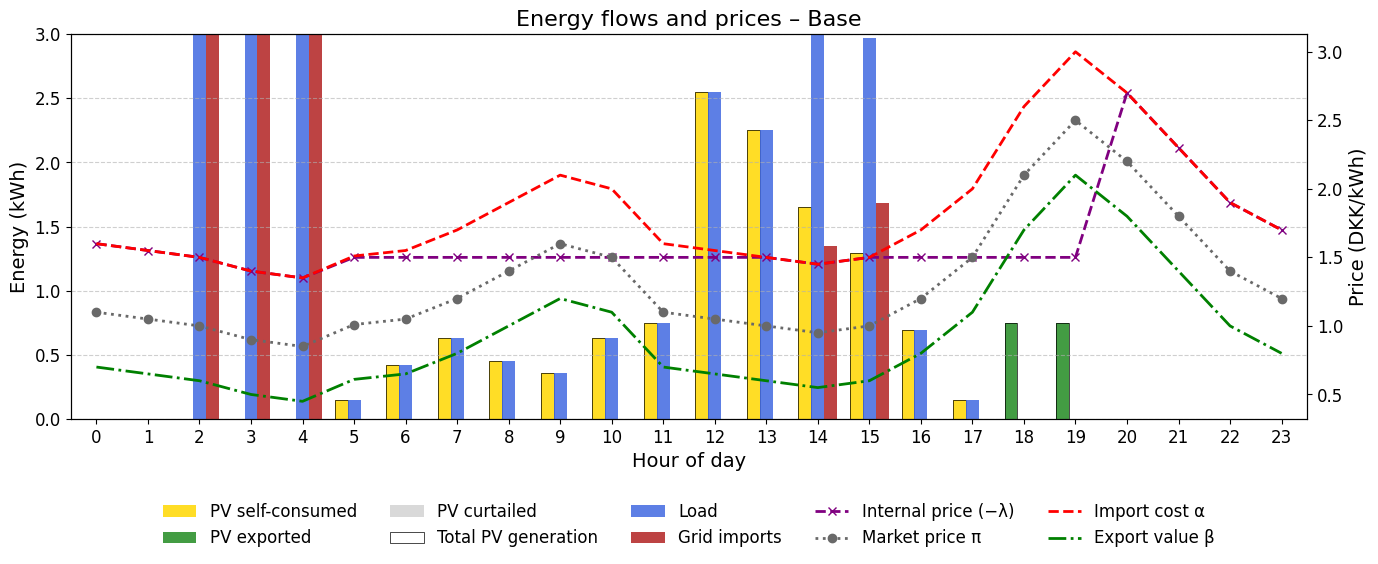

sum of load: 24.0


In [6]:
# --- Base scenario ---
scenario_name = "Base"
sc = scenarios[scenario_name]

# 1) Build input data
input_data = build_input_data(base, sc)

# 2) Run optimization
problem = classes.LP_OptimizationProblem(input_data)
problem.run()

# 3) Convert results to DataFrame
df = helpers.results_to_dataframe(problem.results, base["T"])

# 4) Extract duals (λ_t for hourly balance constraints)
duals = [problem.results.duals[f"constr[{i}]"] for i in range(1, base["T"]+1)]

# 5) Plot
plots.plot_hourly_flows_with_prices(
    df,
    scenario_name,
    duals=duals,
    price=sc["price"],
    alpha=sc["price"] + sc["imp"],
    beta=sc["price"] - sc["exp"]
)
print("sum of load:", df["l"].sum())

### 5.2 Constant Price Scenario

Flat electricity pricing removes temporal arbitrage opportunities. Load scheduling becomes driven purely by PV availability rather than price signals.

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 73 rows, 120 columns and 192 nonzeros
Model fingerprint: 0xa3748e18
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+01]
Presolve removed 57 rows and 74 columns
Presolve time: 0.00s
Presolved: 16 rows, 46 columns, 61 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.2381175e+01   1.200000e+01   0.000000e+00      0s
       4    1.9155825e+01   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.915582500e+01


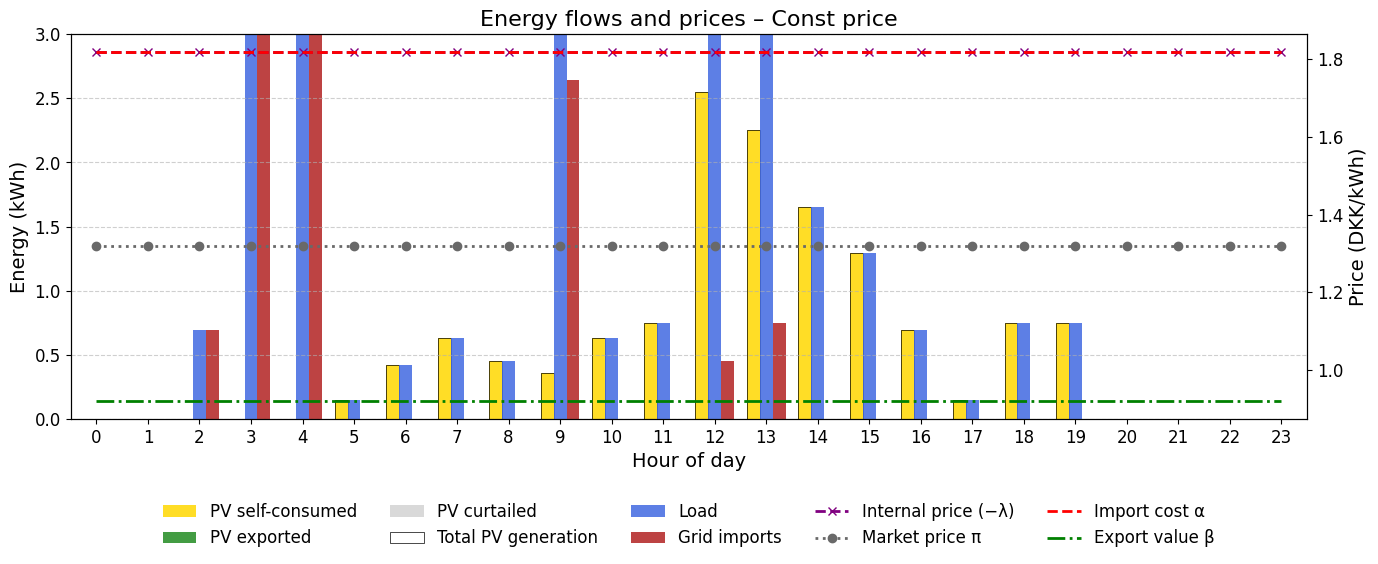

sum of load: 24.0


In [7]:
# --- Constant price scenario ---
scenario_name = "Const price"
sc = scenarios[scenario_name]

# 1) Build input data
input_data = build_input_data(base, sc)

# 2) Run optimization
problem = classes.LP_OptimizationProblem(input_data)
problem.run()

# 3) Convert results to DataFrame
df = helpers.results_to_dataframe(problem.results, base["T"])

# 4) Extract duals (λ_t for hourly balance constraints)
duals = [problem.results.duals[f"constr[{i}]"] for i in range(1, base["T"]+1)]

# 5) Plot
plots.plot_hourly_flows_with_prices(
    df,
    scenario_name,
    duals=duals,
    price=sc["price"],
    alpha=sc["price"] + sc["imp"],
    beta=sc["price"] - sc["exp"]
)
print("sum of load:", df["l"].sum())

### 5.3 Net Metering Scenario

Zero grid tariffs (τᵢᵐᵖ = τᵉˣᵖ = 0) create perfect price symmetry. Consumer can import/export at market price without additional fees.

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 73 rows, 120 columns and 192 nonzeros
Model fingerprint: 0x76befe91
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+01]
Presolve removed 72 rows and 105 columns
Presolve time: 0.00s
Presolved: 1 rows, 15 columns, 15 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6612500e+01   1.200000e+01   0.000000e+00      0s
       1    6.6675000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.667500000e+00


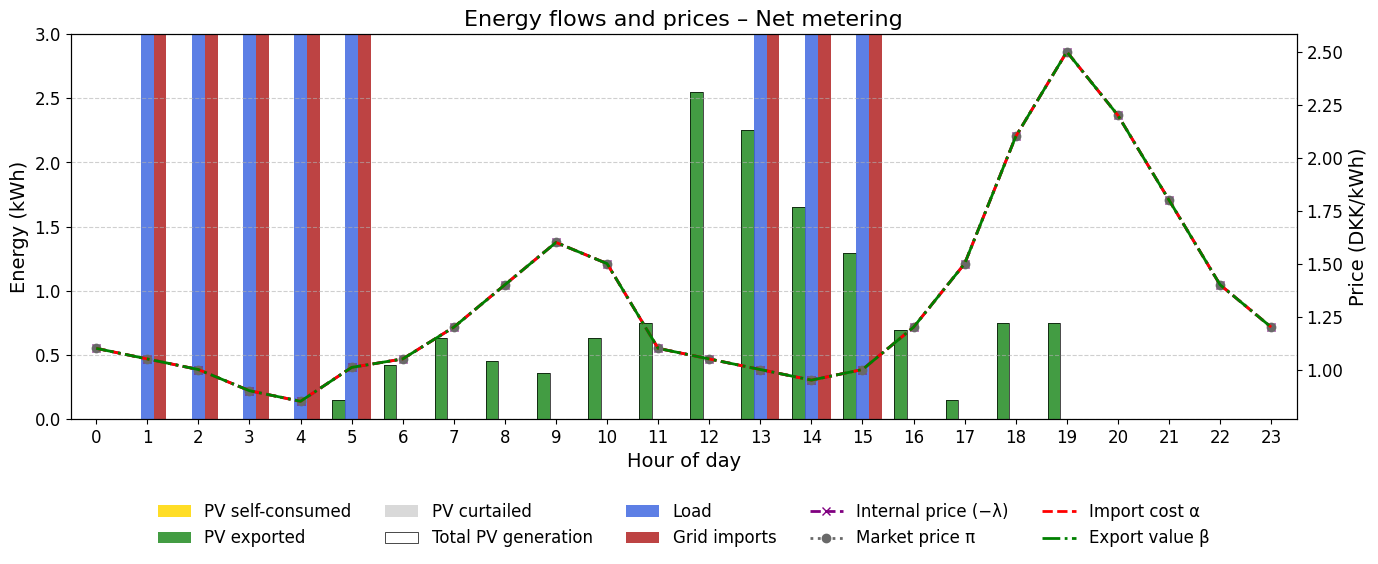

sum of load: 24.0


In [8]:
# --- Net metering scenario ---
scenario_name = "Net metering"
sc = scenarios[scenario_name]

# 1) Build input data
input_data = build_input_data(base, sc)

# 2) Run optimization
problem = classes.LP_OptimizationProblem(input_data)
problem.run()

# 3) Convert results to DataFrame
df = helpers.results_to_dataframe(problem.results, base["T"])

# 4) Extract duals (λ_t for hourly balance constraints)
duals = [problem.results.duals[f"constr[{i}]"] for i in range(1, base["T"]+1)]

# 5) Plot
plots.plot_hourly_flows_with_prices(
    df,
    scenario_name,
    duals=duals,
    price=sc["price"],
    alpha=sc["price"] + sc["imp"],
    beta=sc["price"] - sc["exp"]
)
print("sum of load:", df["l"].sum())

Note for net metering: simultanous import/export is due to collapsed price band, effectively the imported kwh are only the difference of load to pv export - this has no influence on the objective value and can be post processed as seen later in this notebook. For a more detailed explanation refer to the report.

### 5.4 No Export Scenario

Unfavorable export pricing (τᵉˣᵖ = π + 0.01) makes grid export unprofitable. Consumer must either self-consume PV or curtail excess production.

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 73 rows, 120 columns and 192 nonzeros
Model fingerprint: 0x0f92c6e9
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+01]
Presolve removed 57 rows and 66 columns
Presolve time: 0.00s
Presolved: 16 rows, 54 columns, 69 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.400000e+01   0.000000e+00      0s
      23    1.4977500e+01   0.000000e+00   0.000000e+00      0s

Solved in 23 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.497750000e+01


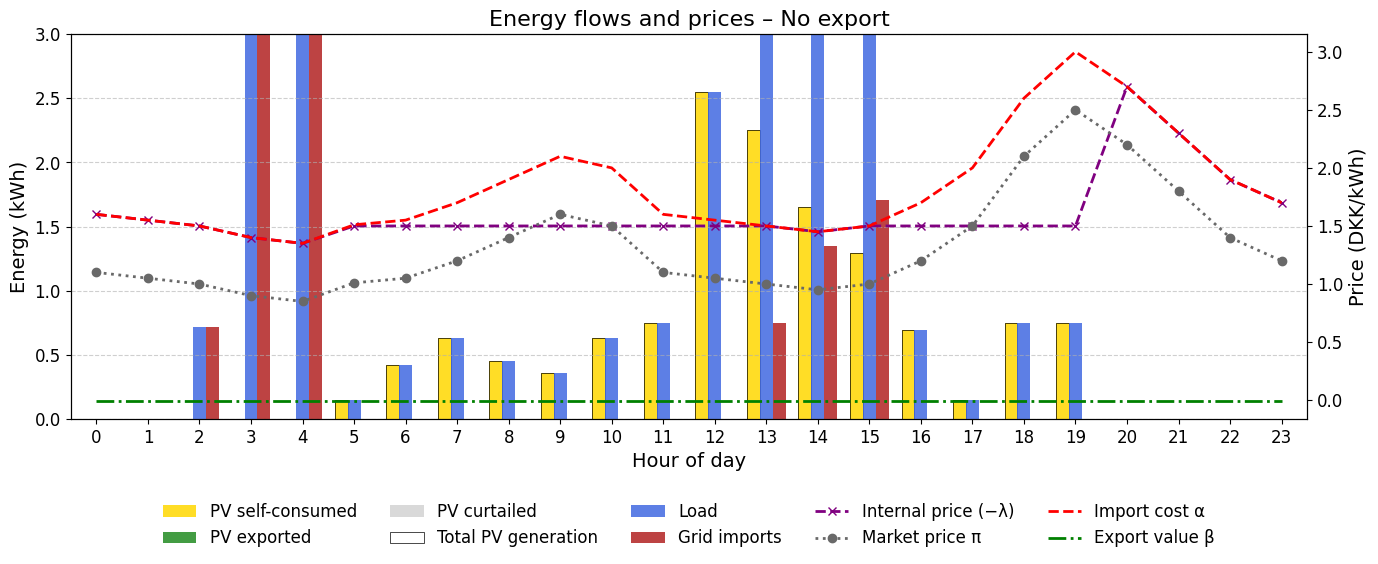

sum of load: 24.0


In [9]:
# --- No export scenario ---
scenario_name = "No export"
sc = scenarios[scenario_name]

# 1) Build input data
input_data = build_input_data(base, sc)

# 2) Run optimization
problem = classes.LP_OptimizationProblem(input_data)
problem.run()

# 3) Convert results to DataFrame
df = helpers.results_to_dataframe(problem.results, base["T"])

# 4) Extract duals (λ_t for hourly balance constraints)
duals = [problem.results.duals[f"constr[{i}]"] for i in range(1, base["T"]+1)]

# 5) Plot
plots.plot_hourly_flows_with_prices(
    df,
    scenario_name,
    duals=duals,
    price=sc["price"],
    alpha=sc["price"] + sc["imp"],
    beta=sc["price"] - sc["exp"]
)
print("sum of load:", df["l"].sum())

### 5.5 Price Spike Scenario

Evening price volatility (2× price during hours 18-22)

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 73 rows, 120 columns and 192 nonzeros
Model fingerprint: 0x49b87c59
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 6e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+01]
Presolve removed 57 rows and 66 columns
Presolve time: 0.00s
Presolved: 16 rows, 54 columns, 69 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4674500e+01   2.400000e+01   0.000000e+00      0s
       2    1.0927500e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.092750000e+01


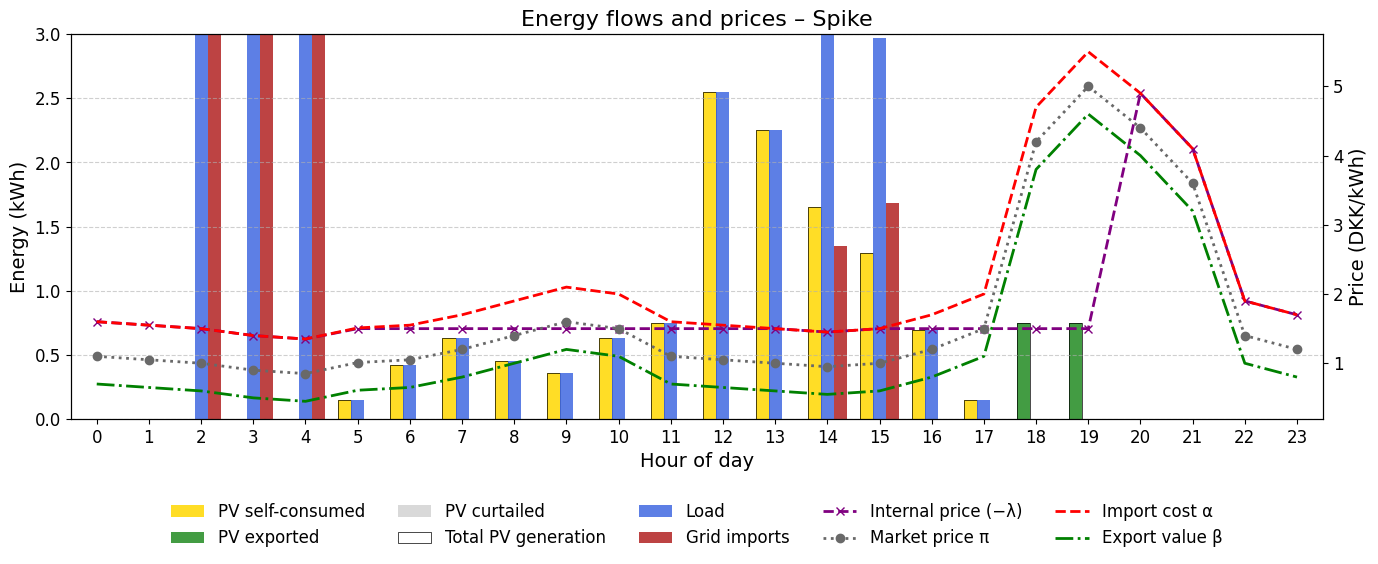

sum of load: 24.0


In [10]:
# --- Evening spike scenario ---
scenario_name = "Spike"
sc = scenarios[scenario_name]

# 1) Build input data
input_data = build_input_data(base, sc)

# 2) Run optimization
problem = classes.LP_OptimizationProblem(input_data)
problem.run()

# 3) Convert results to DataFrame
df = helpers.results_to_dataframe(problem.results, base["T"])

# 4) Extract duals (λ_t for hourly balance constraints)
duals = [problem.results.duals[f"constr[{i}]"] for i in range(1, base["T"]+1)]

# 5) Plot
plots.plot_hourly_flows_with_prices(
    df,
    scenario_name,
    duals=duals,
    price=sc["price"],
    alpha=sc["price"] + sc["imp"],
    beta=sc["price"] - sc["exp"]
)
print("sum of load:", df["l"].sum())

## 6. Comparative Analysis & Reporting

### Multi-Scenario Results Summary

Compare optimization results across all scenarios to understand:
- **Economic impact**: How different cost structures affect total costs
- **Flexibility utilization**: Load shifting patterns and PV self-consumption
- **Market interaction**: Import/export volumes and curtailment levels
- **Dual variable insights**: Shadow prices revealing system constraints

The analysis includes both primal results (energy flows) and dual results (constraint shadow prices) to provide economic interpretation of the optimization outcomes.

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 73 rows, 120 columns and 192 nonzeros
Model fingerprint: 0xc2749489
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+01]
Presolve removed 57 rows and 66 columns
Presolve time: 0.00s
Presolved: 16 rows, 54 columns, 69 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1224500e+01   2.400000e+01   0.000000e+00      0s
       2    1.4377500e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.437750000e+01
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up 

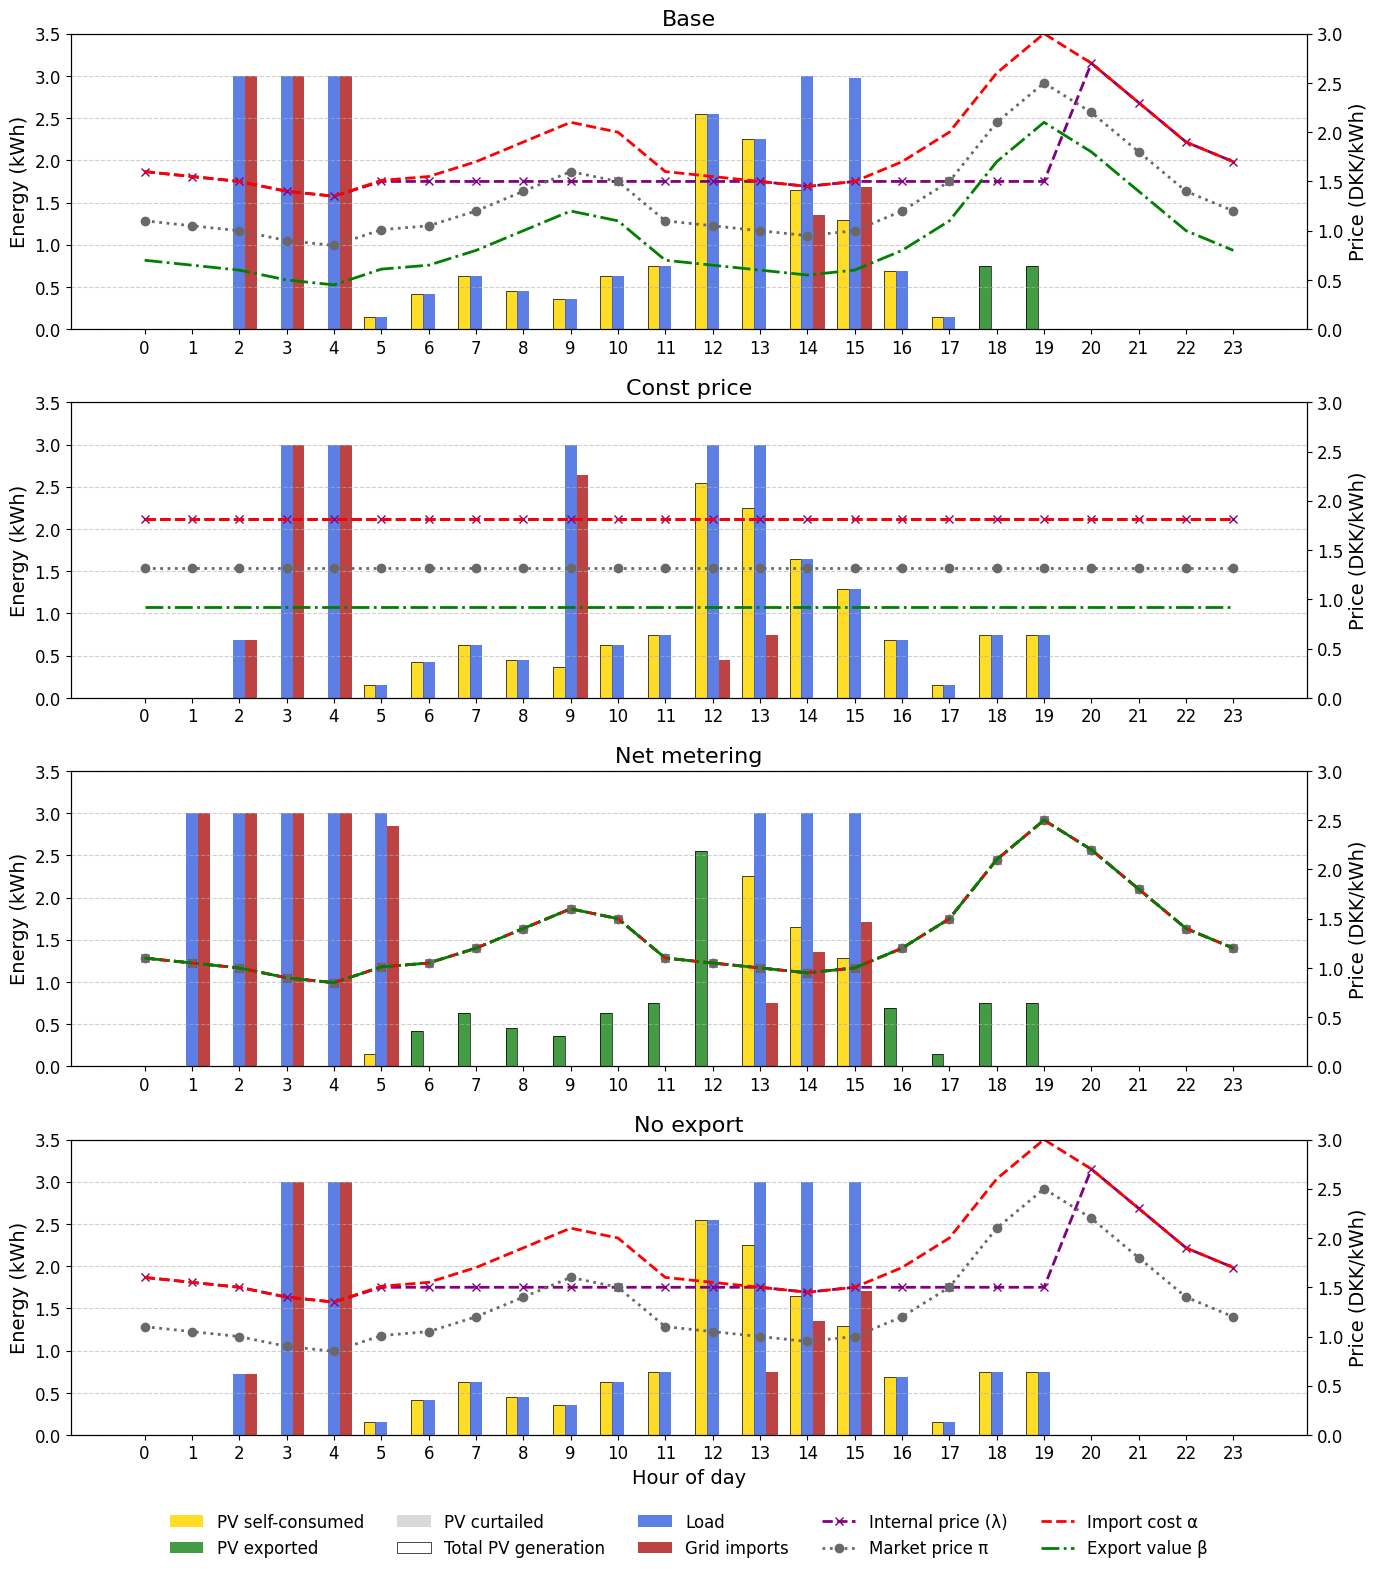

In [11]:
scenario_names = ["Base", "Const price", "Net metering", "No export"]

dfs, duals_list, price_list, alpha_list, beta_list = [], [], [], [], []
results_summary = {}

for scenario_name in scenario_names:
    sc = scenarios[scenario_name]
    input_data = build_input_data(base, sc)
    problem = classes.LP_OptimizationProblem(input_data)
    problem.run()

    # --- Get results as DataFrame ---
    df = helpers.results_to_dataframe(problem.results, base["T"])

    # --- Apply cleaning only for Net Metering ---
    if scenario_name == "Net metering":
        df = helpers.clean_net_metering_solution(df)

    dfs.append(df)

    # --- Store duals etc. ---
    duals = [problem.results.duals[f"constr[{i}]"] for i in range(1, base["T"]+1)]
    duals_list.append(duals)
    price_list.append(sc["price"])
    alpha_list.append(sc["price"] + sc["imp"])
    beta_list.append(sc["price"] - sc["exp"])

    mu = problem.results.duals["constr[0]"]
    lambdas = duals
    rhos = [problem.results.duals[f"constr[{i}]"] for i in range(base["T"]+1, 2*base["T"]+1)]

    results_summary[scenario_name] = {
        "Objective": problem.results.objective_value,
        "Total import": df["e"].sum(),
        "Total export": df["s"].sum(),
        "Total curtailed": df["c"].sum(),
        "Total load": df["l"].sum(),
        "mu": mu,
        "lambda_mean": np.mean(lambdas),
        "lambda_min": np.min(lambdas),
        "lambda_max": np.max(lambdas),
        "rho_mean": np.mean(rhos),
    }

# Convert results to DataFrame for later export
df_results = pd.DataFrame(results_summary).T

# Print LaTeX table
print(df_results.to_latex(float_format="%.2f", caption="Primal and dual results by scenario", label="tab:results"))

# Plot all in one figure (4 rows × 1 col)
plots.plot_scenarios_subplots_1a(dfs, scenario_names, price_list, alpha_list, beta_list, duals_list)